In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.time import Time
from astropy.timeseries import LombScargle
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import celerite
from celerite import terms
from scipy.optimize import minimize

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [ ]:
file = 'aavsodata_5f20eb1154bf8.txt'
df = pd.read_csv(file)
# df

In [ ]:
df.columns

In [ ]:
vok = np.where((df['Uncertainty'] < 0.1) &          # select only "good" data
               (df['Band'] == 'V') &                # in V band
               (df['JD'] > (2459059.6638 - 40*365)) # within last ~40yrs
              )[0]

np.size(vok) # how many data points do we have?

In [ ]:
# manually add data from the STEREO ATel
new_dates = Time(['2020-06-24', '2020-7-13', '2020-07-20'], format='isot', scale='utc')
new_mags = [0.66, 0.76, 0.80]
new_errs = [0.015, 0.015, 0.015]

In [ ]:
time = Time(df['JD'].values[vok], format='jd')

XX = time.to_value('decimalyear')
YY = df['Magnitude'][vok].astype('float').values
EE = df['Uncertainty'][vok].values

XX = np.append(XX, new_dates.to_value('decimalyear'))
YY = np.append(YY, new_mags)
EE = np.append(EE, new_errs)

ss = np.argsort(XX)
XX = XX[ss]
YY = YY[ss]
EE = EE[ss]

In [ ]:
frequency, power = LombScargle(XX, YY).autopower(minimum_frequency=1./10, maximum_frequency=1./0.1)
plt.plot(1./frequency, power)
plt.xscale('log')
plt.plot([420/365., 420/365.], [0,0.3], c='C1', lw=3, alpha=0.5) # Dupree+(1987)
plt.plot([5.78, 5.78], [0,0.3], c='C2', lw=3, alpha=0.5) # Goldberg(1984)

plt.xlabel('Period (years)')

# Uh oh, that 1-yr alias...
print(1./frequency[np.argmax(power)])

Now let try the ACF

In [ ]:
# There's a problem we run in to... there are datapoints with the same timestamps,
# and the delta-time distribution is very wide...
dok = np.where((np.diff(XX) > 0.00))[0]
_ = plt.hist(np.log10(np.diff(XX)[dok]))

In [ ]:
# This is an issue b/c the ACF estimator resamples the data onto a uniform grid
# based on the minimum delta-time... making 40yrs @ minutes cadence SUPER slow 

dok = np.where((np.diff(XX) > 1e-4))[0]

acf = xo.autocorr_estimator(XX[dok], YY[dok], yerr=EE[dok], oversample=1,
                            min_period=0.01, max_period=5, max_peaks=3)
acf['peaks']

In [ ]:
# Hmm, also doesn't get the right period quite... still loves that 1-yr alias!
plt.plot(acf['autocorr'][0],acf['autocorr'][1])
plt.plot([420/365., 420/365.], [-.2,1], c='C1', lw=3, alpha=0.5) # Dupree+(1987)
plt.plot([5.78, 5.78], [-.2,1], c='C2', lw=3, alpha=0.5) # Goldberg(1984)

plt.xlim(0,15)

In [9]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp,):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

In [97]:
bounds = dict(log_S0=(-0, 15), log_Q=(-15, 15), log_omega0=(-15, 15))

EPAD = 0.02 # add extra Yerror term to "account" for scatter

Q = 1.0 / np.sqrt(2.0)
w0 = .01
S0 = np.var(YY) / (w0 * Q)
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), 
                       log_omega0=np.log(w0), bounds=bounds)
kernel.freeze_parameter("log_Q") 
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), 
                       log_omega0=np.log(w0), bounds=bounds)

# kernel += terms.RealTerm(log_a=np.log(np.var(YY)), log_c=-np.log(10.0))


In [98]:
gp0 = celerite.GP(kernel, mean=np.mean(YY), fit_mean=True)
gp0.compute(XX, yerr=EE + EPAD) 

bounds = gp0.get_parameter_bounds()
initial_params = gp0.get_parameter_vector()

soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method='L-BFGS-B', bounds=bounds, args=(YY, gp0))
gp0.set_parameter_vector(soln.x)

xnew = np.linspace(XX.min(), 2022, 1500)
mu0, var0 = gp0.predict(YY, xnew, return_var=True)

In [99]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', 0.0),
             ('kernel:terms[0]:log_omega0', 0.6508184686729105),
             ('kernel:terms[1]:log_S0', 0.0),
             ('kernel:terms[1]:log_Q', -2.9979978011791717),
             ('kernel:terms[1]:log_omega0', -7.764262001828622),
             ('mean:value', 0.5827662356117205)])

In [100]:
# This gives us... some other period entirely right now. Huh... 2.7yrs??
print(2*np.pi/np.exp(gp.get_parameter_dict()['kernel:terms[0]:log_omega0']))

3.2774267850098253


Text(0, 0.5, 'V mag')

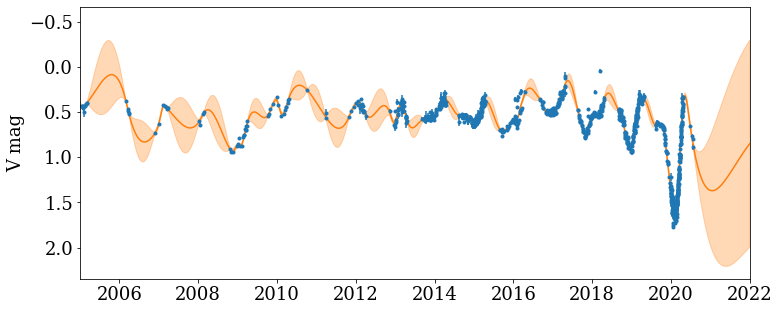

In [101]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

plt.plot(xnew, mu0)
plt.fill_between(xnew, mu0+np.sqrt(var0), mu0-np.sqrt(var0), color='C1', alpha=0.3,
                 edgecolor="none")
plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

In [70]:
# lets switch from using celerite directly to the tutorial from exoplanet
# https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

In [83]:
KNOWNPERIOD = 432 # guess from lit search...

with pm.Model() as model:

    # The mean flux of the time series (V mag in this case)
    mean = pm.Normal("mean", mu=np.mean(YY), sd=2.)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(EE)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(YY)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(YY)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(KNOWNPERIOD), sd=15.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, XX, EE ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=YY)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
191it [00:01, 105.62it/s, logp=2.635785e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: -2266.3004107546785 -> 2635.785156373321


In [84]:
map_soln

{'mean': array(0.5543946),
 'logs2': array(-6.89369749),
 'logSw4': array(2.88120526),
 'logw0': array(2.01848032),
 'logamp': array(-5.61728116),
 'logperiod_interval__': array(-0.13954372),
 'logQ0': array(-0.12362472),
 'logdeltaQ': array(5.44261562),
 'mix_logodds__': array(-0.09312531),
 'logperiod': array(1.81975797),
 'mix': array(0.47673548),
 'period': array(6.17036484),
 'pred': array([0.03312092, 0.03798333, 0.08790959, ..., 0.22113382, 0.26144195,
        0.27340662])}

Text(0, 0.5, 'V mag')

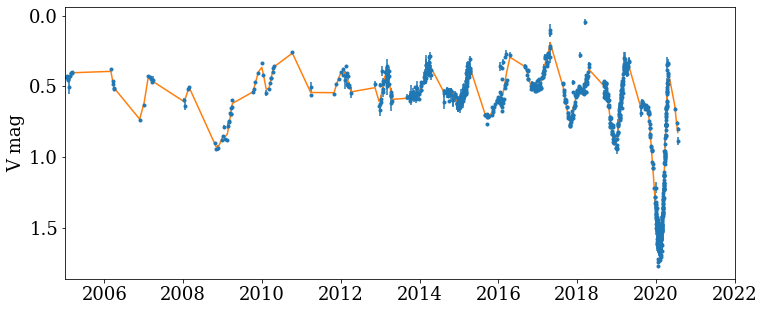

In [86]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

plt.plot(XX, map_soln["pred"] + map_soln['mean'], c='C1')
# plt.fill_between(xnew, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
#                  edgecolor="none")
plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

In [87]:
with model:
    trace = pm.sample(tune=500, draws=2000, start=map_soln, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [01:59<00:00, 16.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [92]:
trace[1]

{'mean': 0.5479318231945838,
 'logs2': -6.903686137276609,
 'logSw4': -1.8460946661260962,
 'logw0': 0.6589243843659609,
 'logamp': -3.728904437276591,
 'logperiod_interval__': -4.529363007477952,
 'logQ0': 0.9529656480080704,
 'logdeltaQ': 5.082699360561375,
 'mix_logodds__': -0.7128399754492002,
 'logperiod': 0.041750738067098614,
 'mix': 0.32897161339155423,
 'period': 1.0426345572527909,
 'pred': array([0.03733969, 0.03935773, 0.08977282, ..., 0.23690989, 0.27880817,
        0.29040779])}

In [115]:
xnew = np.linspace(XX.min(), 2022, 1500)

with model:
    mu, var = xo.eval_in_model(gp.predict(xnew, return_var=True), trace[1])

ValueError: dimension mismatch

Text(0, 0.5, 'V mag')

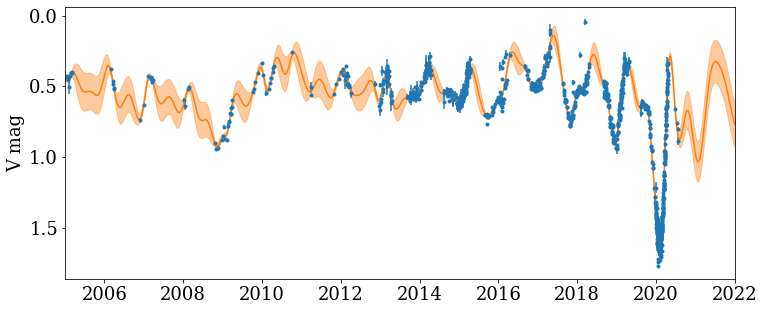

In [116]:
plt.figure(figsize=(12, 5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

plt.plot(xnew, mu+trace[1]['mean'], c='C1')
plt.fill_between(xnew, mu-np.sqrt(var)+trace[1]['mean'], 
                 mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C1')

plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

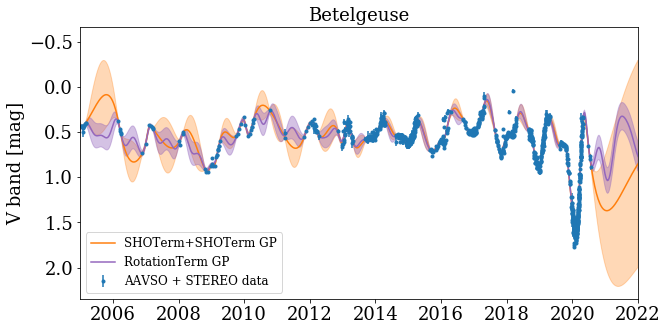

In [131]:
plt.figure(figsize=(10, 5))

plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.', label='AAVSO + STEREO data')

plt.plot(xnew, mu0, c='C1', label='SHOTerm+SHOTerm GP')
plt.fill_between(xnew, mu0+np.sqrt(var0), mu0-np.sqrt(var0), color='C1', alpha=0.3,
                 edgecolor="none")


plt.plot(xnew, mu+trace[1]['mean'], c='C4', label='RotationTerm GP')
plt.fill_between(xnew, mu-np.sqrt(var)+trace[1]['mean'], mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C4')

plt.xlim(2005,2022)
plt.gca().invert_yaxis()
plt.legend(fontsize=12,loc='lower left')
plt.ylabel('V band [mag]')
plt.title('Betelgeuse', fontsize=18)
plt.savefig('gp.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5, 1.0, 'Betelgeuse')

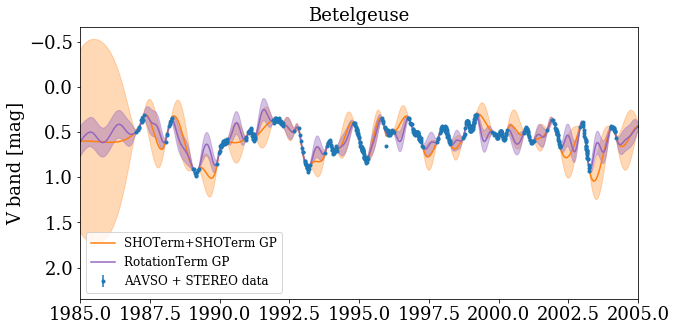

In [133]:
plt.figure(figsize=(10, 5))

plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.', label='AAVSO + STEREO data')

plt.plot(xnew, mu0, c='C1', label='SHOTerm+SHOTerm GP')
plt.fill_between(xnew, mu0+np.sqrt(var0), mu0-np.sqrt(var0), color='C1', alpha=0.3,
                 edgecolor="none")


plt.plot(xnew, mu+trace[1]['mean'], c='C4', label='RotationTerm GP')
plt.fill_between(xnew, mu-np.sqrt(var)+trace[1]['mean'], mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C4')

plt.xlim(1985,2005)
plt.gca().invert_yaxis()
plt.legend(fontsize=12,loc='lower left')
plt.ylabel('V band [mag]')
plt.title('Betelgeuse', fontsize=18)


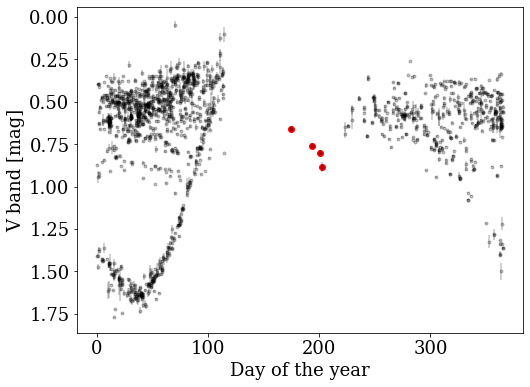

In [147]:
plt.figure(figsize=(8,6))
plt.errorbar((XX % 1)*365.,YY, yerr=EE, linestyle='none', marker='.', alpha=0.24,c='k')
plt.scatter((XX[-4:] % 1)*365., YY[-4:], c='r')
plt.xlabel('Day of the year')
plt.ylabel('V band [mag]')
plt.gca().invert_yaxis()